In [1]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
sys.path = sys.path[1:]
sys.path.append(os.path.abspath(os.pardir))
#sys.path.append(os.path.join(os.path.abspath(os.pardir), 'odometry'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tfoptflow/tfoptflow'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tf_models/research/struct2depth'))

In [3]:
from odometry.preprocessing.estimators import *
from odometry.preprocessing.prepare_trajectory import prepare_trajectory


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Data

In [4]:
from odometry.preprocessing.data_parser import (KITTIParser,
                                                TUMParser,
                                                RetailBotParser,
                                                DISCOMANParser)

### TUM

In [5]:
sequence_directory = 'tum'
directory = '/Vol1/dbstore/datasets/tum_rgbd_flow/data/rgbd_dataset_freiburg2_coke'
height, width = 480, 640
tum_parser = TUMParser(sequence_directory, directory=directory)

### RetailBot

In [6]:
sequence_directory = 'retailbot'
directory = '/dbstore/datasets/retail_bot/meetingroom_04_rgbd_ir_imu_pose'
height, width = 480, 640
retailbot_parser = RetailBotParser(sequence_directory, directory=directory)

### DISCOMAN

In [7]:
sequence_directory = 'discoman'
json_path = '/dbstore/datasets/renderbox/iros2019/dset/output/deprecated/000001/0_traj.json'
height, width = 120, 160
discoman_parser = DISCOMANParser(directory, json_path=json_path)

### KITTI

In [8]:
sequence_directory = 'kitti'
seq_id = '01'
height, width = 94, 300
kitti_parser = KITTIParser(sequence_directory, seq_id=seq_id)

In [9]:
#parser = tum_parser
parser = kitti_parser
#parser = discoman_parser
#parser = retailbot_parser

## Estimators

### Quaternion2Euler

In [10]:
input_col = ['q_w', 'q_x', 'q_y', 'q_z']
output_col = ['euler_x', 'euler_y', 'euler_z']
quaternion2euler_estimator = Quaternion2EulerEstimator(input_col=input_col, output_col=output_col)
quaternion2euler_estimator

Estimator(input_col=['q_w', 'q_x', 'q_y', 'q_z'], output_col=['euler_x', 'euler_y', 'euler_z'])

### Struct2depth

In [11]:
depth_checkpoint = os.path.abspath('../weights/model-199160')
depth_checkpoint

'/Vol0/user/a.vorontsova/odometry/weights/model-199160'

In [12]:
struct2depth_estimator = Struct2DepthEstimator(input_col='path_to_rgb',
                                               output_col='path_to_depth',
                                               directory='depth',
                                               checkpoint=depth_checkpoint, 
                                               height=height,
                                               width=width)
struct2depth_estimator

Instructions for updating:
Colocations handled automatically by placer.


W0613 19:28:48.074822 47588562574976 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.batch_normalization instead.


W0613 19:28:48.151336 47588562574976 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tf_models/research/struct2depth/nets.py:503: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.
W0613 19:28:50.424251 47588562574976 util.py:204] Shape mismatch, will not restore egomotion_prediction/pose_exp_net/pose/cnv6/weights.
W0613 19:28:50.425063 47588562574976 util.py:206] The following variables in the checkpoint were not loaded:


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0613 19:28:51.461205 47588562574976 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


I0613 19:28:51.463732 47588562574976 saver.py:1270] Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


Estimator(dir=depth, input_col=path_to_rgb, output_col=path_to_depth, checkpoint=/Vol0/user/a.vorontsova/odometry/weights/model-199160)

### Global2relative

In [13]:
input_col = ['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z', 
             'euler_x_next', 'euler_y_next', 'euler_z_next', 't_x_next', 't_y_next', 't_z_next']
output_col = ['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z']
global2relative_estimator = Global2RelativeEstimator(input_col=input_col, output_col=output_col)
global2relative_estimator

Estimator(input_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z', 'euler_x_next', 'euler_y_next', 'euler_z_next', 't_x_next', 't_y_next', 't_z_next'], output_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z'])

### PWC-Net

In [14]:
optical_flow_checkpoint = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'
#optical_flow_checkpoint = os.path.abspath(../weights/pwcnet.ckpt-595000')  # official weights
optical_flow_checkpoint

'/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'

In [15]:
pwcnet_estimator = PWCNetEstimator(input_col=['path_to_rgb', 'path_to_rgb_next'],
                                   output_col='path_to_optical_flow',
                                   directory='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width)
pwcnet_estimator

Building model...
Instructions for updating:
Use keras.layers.conv2d instead.


W0613 19:29:12.127458 47588562574976 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1173: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.conv2d_transpose instead.


W0613 19:29:13.449591 47588562574976 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1300: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


... model built.
Loading model checkpoint /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000 for eval or testing...

INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0613 19:29:17.562922 47588562574976 saver.py:1270] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


... model loaded


Estimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb_next'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [16]:
single_frame_estimators = [quaternion2euler_estimator, struct2depth_estimator]
pair_frames_estimators = [global2relative_estimator, pwcnet_estimator]

## Prepare trajectory (ex-Builder)

In [17]:
prepare_trajectory(sequence_directory, 
                   parser=parser, 
                   single_frame_estimators=single_frame_estimators,
                   pair_frames_estimators=pair_frames_estimators,
                   stride=1)

Parse ok...


100%|██████████| 1100/1100 [02:21<00:00,  8.74it/s]


,path_to_rgb,t_x,t_y,t_z,euler_x,euler_y,euler_z,path_to_depth,path_to_rgb_next,t_x_next,t_y_next,t_z_next,euler_x_next,euler_y_next,euler_z_next,path_to_depth_next,path_to_optical_flow
0,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.051547,-0.024249,1.000725,0.002579,0.043561,0.001762,kitti/depth/0.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.051547,-0.024249,1.000725,0.002579,0.043561,0.001762,kitti/depth/1.npy,kitti/optical_flow/1.npy
1,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.051453,-0.023860,0.998186,0.004748,0.045163,0.004143,kitti/depth/1.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.146463,-0.050516,1.995659,0.007516,0.088713,0.006034,kitti/depth/2.npy,kitti/optical_flow/2.npy
2,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.052924,-0.021854,0.999845,0.004483,0.045897,0.001125,kitti/depth/2.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.287920,-0.079031,2.986691,0.012138,0.134601,0.007516,kitti/depth/3.npy,kitti/optical_flow/3.npy
3,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.044855,-0.020553,0.992470,0.003060,0.046507,-0.001787,kitti/depth/3.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.465750,-0.110293,3.963845,0.015044,0.181125,0.006276,kitti/depth/4.npy,kitti/optical_flow/4.npy
4,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.052541,-0.020040,0.996975,0.000078,0.047038,0.002670,kitti/depth/4.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.697164,-0.143877,4.934639,0.015763,0.228116,0.009739,kitti/depth/5.npy,kitti/optical_flow/5.npy
5,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.051421,-0.023404,0.990787,0.001098,0.046670,0.001533,kitti/depth/5.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.971569,-0.180224,5.887651,0.017411,0.274756,0.012094,kitti/depth/6.npy,kitti/optical_flow/6.npy
6,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.049531,-0.024862,0.989671,0.003614,0.046159,0.003601,kitti/depth/6.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,1.288079,-0.218488,6.826202,0.022303,0.320842,0.016731,kitti/depth/7.npy,kitti/optical_flow/7.npy
7,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.054665,-0.020330,0.985966,0.002862,0.045028,0.004184,kitti/depth/7.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,1.651331,-0.254729,7.743952,0.026940,0.365761,0.022280,kitti/depth/8.npy,kitti/optical_flow/8.npy
8,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.049184,-0.019557,0.985922,0.001173,0.045931,0.000123,kitti/depth/8.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,2.050498,-0.291953,8.646240,0.028672,0.411672,0.023764,kitti/depth/9.npy,kitti/optical_flow/9.npy
9,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,0.048030,-0.021187,0.983463,-0.000189,0.046545,0.000775,kitti/depth/9.npy,/Vol0/user/a.vorontsova/odometry/notebooks/kit...,2.488685,-0.330924,9.527392,0.029455,0.458174,0.026114,kitti/depth/10.npy,kitti/optical_flow/10.npy


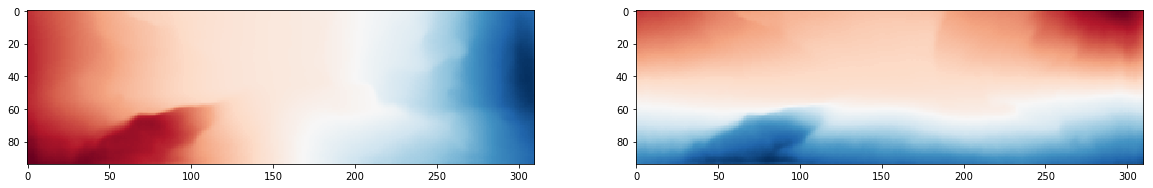

In [18]:
optical_flow_directory = os.path.join(sequence_directory, 'optical_flow')
flow = np.load(os.path.join(optical_flow_directory, os.listdir(optical_flow_directory)[0]))

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].imshow(flow[..., 0], cmap='RdBu')
ax[1].imshow(flow[..., 1], cmap='RdBu')
plt.show()

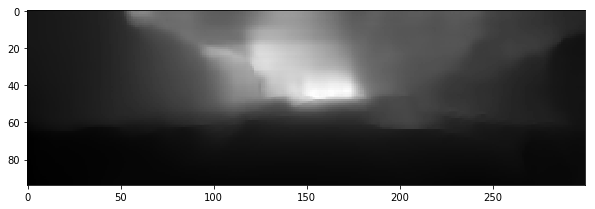

In [19]:
depth_directory = os.path.join(sequence_directory, 'depth')
depth = np.load(os.path.join(depth_directory, os.listdir(depth_directory)[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(depth[..., 0], cmap='gray')
plt.show()